In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import time
import datetime
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from easydict import EasyDict as ed

In [2]:
cdf = pd.read_csv('../data/CAISO-20170701-20201030.csv',parse_dates=['start_dt', 'end_dt'])

In [3]:
edf = pd.read_csv('../data/EIA-20180701-20201109.csv', index_col=0, parse_dates=['dt'])

In [4]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28232 entries, 0 to 28231
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   start_dt                  28232 non-null  datetime64[ns, UTC]
 1   end_dt                    28232 non-null  datetime64[ns, UTC]
 2   total_integrated_load_MW  28232 non-null  int64              
 3   solar_generation_MW       28232 non-null  float64            
 4   wind_generation_MW        28232 non-null  float64            
 5   covariate_x               28232 non-null  object             
 6   ramp_z                    28232 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(3), int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20689 entries, 0 to 20688
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   dt             20689 non-null  datetime64[ns, UTC]
 1   demand_MWh     20689 non-null  int64              
 2   wind_gen_MWh   20689 non-null  int64              
 3   solar_gen_MWh  20689 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 808.2 KB


In [13]:
# cdf['start_dt'] = cdf['start_dt'].dt.tz_localize(None)
# len(cdf), len(pd.date_range(start=cdf['start_dt'][0],end=cdf['start_dt'][len(cdf)-1],freq='1H'))

(28232, 29224)

In [16]:
# edf['dt'] = edf['dt'].dt.tz_localize(None)
# len(edf),len(pd.date_range(start = edf['dt'][0],end=edf['dt'][len(edf)-1],freq='1H'))

(20689, 20689)

In [48]:
# merge and clean the df

In [49]:
df = cdf.merge(edf, left_on='start_dt', right_on='dt')

In [50]:
df.head(2)

,start_dt,end_dt,total_integrated_load_MW,solar_generation_MW,wind_generation_MW,covariate_x,ramp_z,dt,demand_MWh,wind_gen_MWh,solar_gen_MWh
0,2018-07-01 08:00:00+00:00,2018-07-01 09:00:00+00:00,25444,-18.17598,3614.42703,"[26, 6, 9]",21847.74895,2018-07-01 08:00:00+00:00,26061,3958,0
1,2018-07-01 09:00:00+00:00,2018-07-01 10:00:00+00:00,24056,-18.42822,3556.83377,"[26, 6, 10]",20517.59445,2018-07-01 09:00:00+00:00,24604,4087,0


In [51]:
df = (df.drop(columns=['start_dt', 'end_dt'])
        .rename(columns={'total_integrated_load_MW': 'caiso_load',
                         'solar_generation_MW': 'caiso_solar',
                         'wind_generation_MW': 'caiso_wind',
                         'demand_MWh': 'eia_load',
                         'solar_gen_MWh': 'eia_solar',
                         'wind_gen_MWh': 'eia_wind'})
       .reindex(columns=['dt', 'caiso_load', 'eia_load', 'caiso_solar', 'eia_solar', 'caiso_wind', 'eia_wind'])
       .astype({'caiso_load': float, 'eia_load': float, 'eia_solar': float, 'eia_wind': float})
     )

In [9]:
df['dt'] = df['dt'].dt.tz_convert('US/Pacific')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19771 entries, 0 to 19770
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   dt           19771 non-null  datetime64[ns, UTC]
 1   caiso_load   19771 non-null  float64            
 2   eia_load     19771 non-null  float64            
 3   caiso_solar  19771 non-null  float64            
 4   eia_solar    19771 non-null  float64            
 5   caiso_wind   19771 non-null  float64            
 6   eia_wind     19771 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 1.2 MB


In [11]:
# add some categorical fields for convenience and the ramp calcs

In [53]:
df['cat_hour'] = df['dt'].dt.hour
df['cat_day'] = df['dt'].dt.dayofweek
df['cat_week'] = df['dt'].dt.week
df['cat_month'] = df['dt'].dt.month
df['cat_year'] = df['dt'].dt.year

In [54]:
df['caiso_net_load'] = df['caiso_load'] - df['caiso_solar'] - df['caiso_wind']
df['eia_net_load'] = df['eia_load'] - df['eia_solar'] - df['eia_wind']

In [55]:
df['caiso_ramp'] = df['caiso_net_load'].diff()
df['eia_ramp'] = df['eia_net_load'].diff()

In [56]:
df.head()

,dt,caiso_load,eia_load,caiso_solar,eia_solar,caiso_wind,eia_wind,cat_hour,cat_day,cat_week,cat_month,cat_year,caiso_net_load,eia_net_load,caiso_ramp,eia_ramp
0,2018-07-01 08:00:00+00:00,25444.0,26061.0,-18.17598,0.0,3614.42703,3958.0,8,6,26,7,2018,21847.74895,22103.0,NaN,NaN
1,2018-07-01 09:00:00+00:00,24056.0,24604.0,-18.42822,0.0,3556.83377,4087.0,9,6,26,7,2018,20517.59445,20517.0,-1330.15450,-1586.0
2,2018-07-01 10:00:00+00:00,23064.0,23554.0,-19.48557,0.0,3392.16842,3710.0,10,6,26,7,2018,19691.31715,19844.0,-826.27730,-673.0
3,2018-07-01 11:00:00+00:00,22407.0,22843.0,-20.36934,0.0,3074.91935,3630.0,11,6,26,7,2018,19352.44999,19213.0,-338.86716,-631.0
4,2018-07-01 12:00:00+00:00,22130.0,22538.0,-6.01978,0.0,2633.41362,3156.0,12,6,26,7,2018,19502.60616,19382.0,150.15617,169.0


In [57]:
df.tail()

,dt,caiso_load,eia_load,caiso_solar,eia_solar,caiso_wind,eia_wind,cat_hour,cat_day,cat_week,cat_month,cat_year,caiso_net_load,eia_net_load,caiso_ramp,eia_ramp
19766,2020-10-30 18:00:00+00:00,23224.0,28663.0,8243.72168,9571.0,148.89958,202.0,18,4,44,10,2020,14831.37874,18890.0,-412.22398,-659.0
19767,2020-10-30 19:00:00+00:00,23304.0,28464.0,8151.44188,9828.0,150.94192,275.0,19,4,44,10,2020,15001.61620,18361.0,170.23746,-529.0
19768,2020-10-30 20:00:00+00:00,23561.0,28637.0,8328.81216,9634.0,151.05136,243.0,20,4,44,10,2020,15081.13648,18760.0,79.52028,399.0
19769,2020-10-30 21:00:00+00:00,24153.0,28942.0,8381.43917,10038.0,161.57291,296.0,21,4,44,10,2020,15609.98792,18608.0,528.85144,-152.0
19770,2020-10-30 22:00:00+00:00,24810.0,29691.0,7707.46670,9461.0,135.37680,411.0,22,4,44,10,2020,16967.15650,19819.0,1357.16858,1211.0


In [28]:
df.to_csv('CA-dt-20180701-20201030.csv')

In [16]:
# group by month and hour so we can get a better idea of variance across these dimensions

In [65]:
mu_df = df.groupby([df['cat_month'], df['cat_hour']]).mean().drop(columns=['cat_day', 'cat_week', 'cat_year'])

In [71]:
std_df = df.groupby([df['cat_month'], df['cat_hour']]).std().drop(columns=['cat_day', 'cat_week', 'cat_year'])

In [66]:
mu_df

caiso_load      eia_load  caiso_solar    eia_solar  \
cat_month cat_hour                                                         
1         0         24891.483333  28145.250000   924.046521  2415.566667   
          1         26933.516667  29934.833333    17.662719   650.400000   
          2         27301.316667  32652.233333    -6.169972    46.800000   
          3         26840.700000  33221.483333    -8.570222    12.516667   
          4         26114.033333  32741.733333    -9.309215     6.766667   
...                          ...           ...          ...          ...   
12        19        23257.416667  29044.133333  5379.177316  6368.466667   
          20        23147.266667  28520.816667  5349.424280  6401.516667   
          21        23286.166667  28399.083333  5050.983112  6284.966667   
          22        23679.866667  28410.900000  4329.187782  5674.850000   
          23        24533.655172  28928.310345  2308.629536  4095.724138   

                     caiso_wind     eia_wind  cat_hour  cat_month  \
cat_month cat_hour                                                  
1         0         1072.795652  1298.600000       0.0        1.0   
          1         1102.697602  1344.250000       1.0        1.0   
          2         1107.184980  1357.066667       2.0        1.0   
          3         1096.422299  1374.316667       3.0        1.0   
          4         1072.103315  1328.950000       4.0        1.0   
...                         ...          ...       ...        ...   
12        19         848.743855  1042.300000      19.0       12.0   
          20         882.867778  1085.333333      20.0       12.0   
          21         901.036758  1129.900000      21.0       12.0   
          22         899.793243  1104.583333      22.0       12.0   
          23         884.070571  1092.551724      23.0       12.0   

                    caiso_net_load  eia_net_load   caiso_ramp     eia_ramp  
cat_month cat_hour                                                          
1         0           22894.641160  24431.083333  4330.445936  3966.616667  
          1           25813.156346  27940.183333  2918.515186  3509.100000  
          2           26200.301659  31248.366667   387.145313  3308.183333  
          3           25752.847924  31834.650000  -447.453736   586.283333  
          4           25051.239233  31406.016667  -701.608690  -428.633333  
...                            ...           ...          ...          ...  
12        19          17029.495496  21633.366667  -610.663441  -822.533333  
          20          16914.974608  21033.966667  -114.520888  -599.400000  
          21          17334.146797  20984.216667   419.172189   -49.750000  
          22          18450.885641  21631.466667  1116.738844   647.250000  
          23          21340.955065  23740.034483  2776.499126  1984.258621  

[288 rows x 12 columns]

In [19]:
# set up a dict for easier labeling and then a plotting function

In [75]:
def labels_loader():
    return ed({
        'load': {
            'caiso': mu_df['caiso_load'],
            'eia': mu_df['eia_load'],
            'title': 'Mean Load by Hour of Day',
        },
        'solar': {
            'caiso': mu_df['caiso_solar'],
            'eia': mu_df['eia_solar'],
            'title': 'Mean Solar Generation by Hour of Day',
        },
        'wind': {
            'caiso': mu_df['caiso_wind'],
            'eia': mu_df['eia_wind'],
            'title': 'Mean Wind Generation by Hour of Day',
        },
        'net_load': {
            'caiso': mu_df['caiso_net_load'],
            'eia': mu_df['eia_net_load'],
            'title': 'Mean Net Load by Hour of Day',
        },
        'ramp': {
            'caiso': mu_df['caiso_ramp'],
            'eia': mu_df['eia_ramp'],
            'title': 'Mean Ramp by Hour of Day',
        },
        'ramp_std': {
            'caiso': std_df['caiso_ramp'],
            'eia': std_df['eia_ramp'],
            'title': 'Std Ramp by Hour of Day',
        },
    })

In [76]:
def hourly_mu_plots(label):
    labels = labels_loader()
    
    sns.set()
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(18,6), constrained_layout=True)
    
    for rowi in range(len(axes)):
        for coli in range(len(axes[rowi])):
            cur_ax = axes[rowi][coli]
            month = 1 + rowi * 6 + coli
            cur_ax.plot(labels[label].caiso.loc[month], label='CAISO')
            cur_ax.plot(labels[label].eia.loc[month], label='EIA')
            cur_ax.set_title(calendar.month_name[month])
            cur_ax.set_xticks(np.arange(0, 24, 4))
            if rowi == 1:
                cur_ax.set_xlabel('Hour of Day')
            if coli == 0:
                cur_ax.set_ylabel('MWh')
    
    leg_handles, leg_labels = cur_ax.get_legend_handles_labels()
    fig.legend(leg_handles, leg_labels)
    fig.suptitle(labels[label].title)
    plt.show()
    

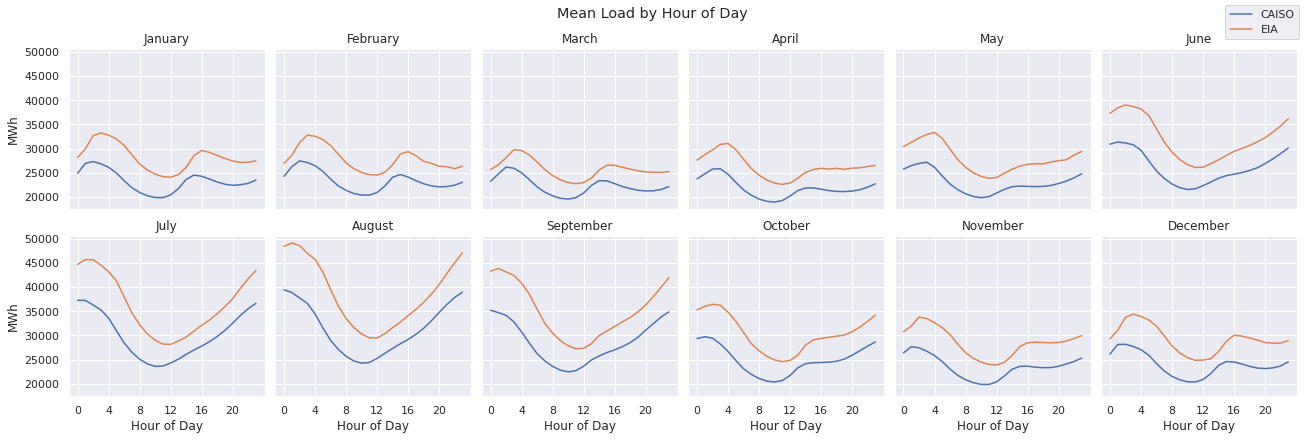

In [77]:
hourly_mu_plots('load')

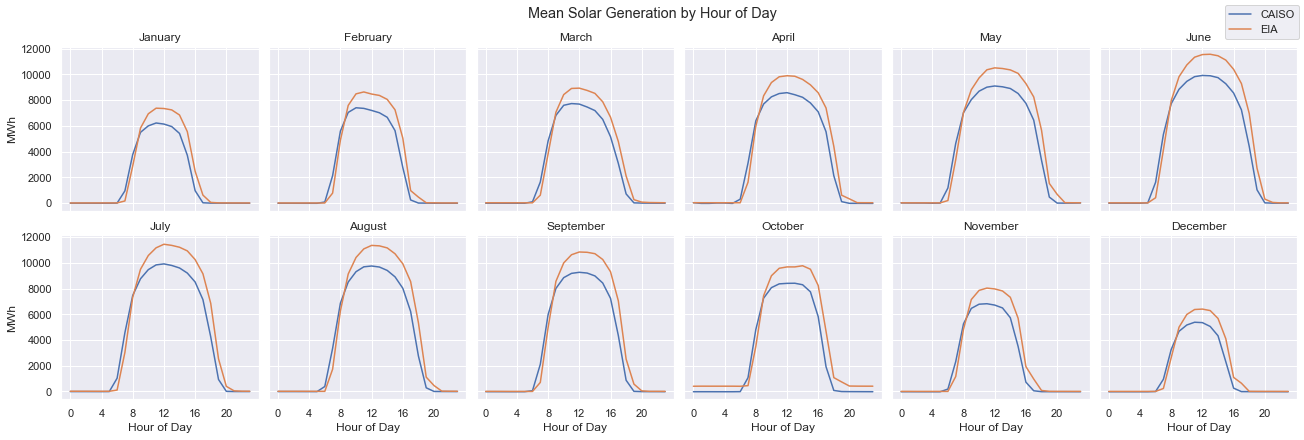

In [23]:
hourly_mu_plots('solar')

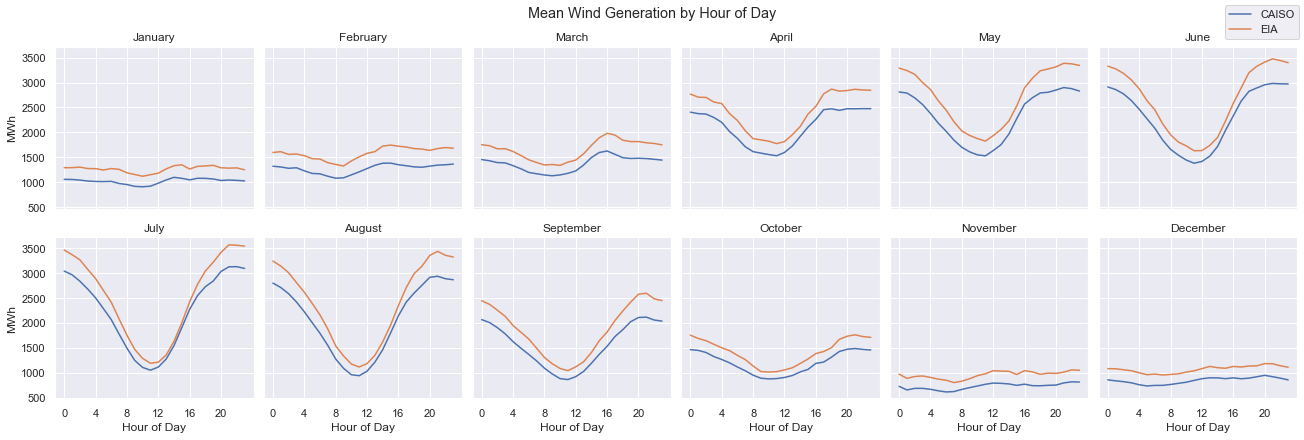

In [24]:
hourly_mu_plots('wind')

In [ ]:
Ramp = Delta(Reserve (t+1) - Reserve (t))
Reserve(t) = Demand - (Solar + Wind)

In [ ]:
3 years - (24 hr,24 hr)


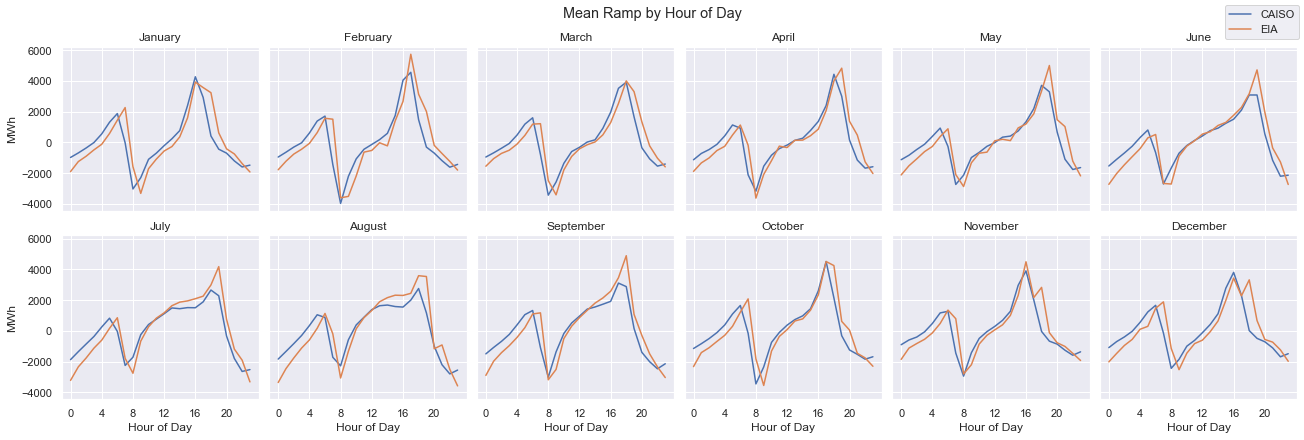

In [25]:
hourly_mu_plots('ramp')

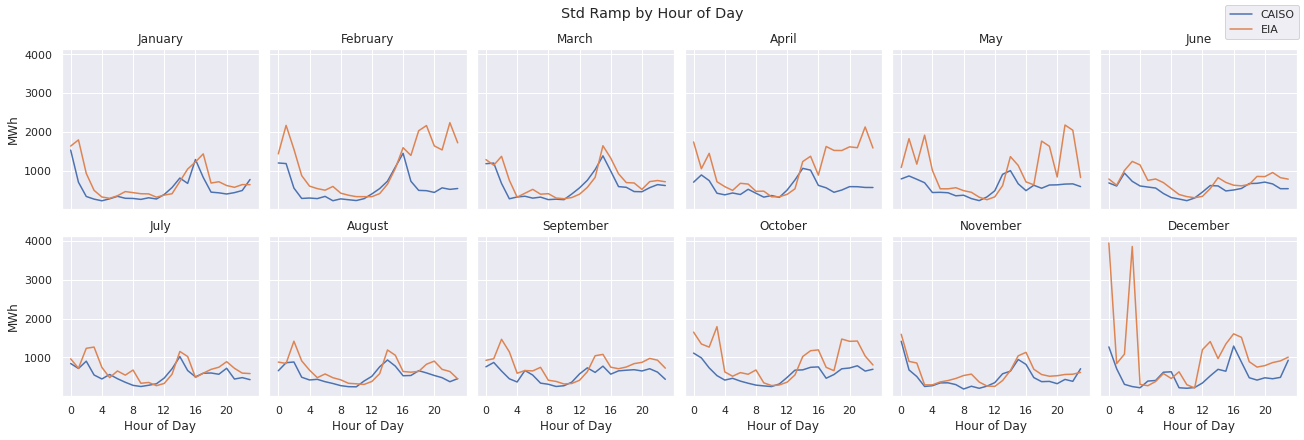

In [78]:
hourly_mu_plots('ramp_std')

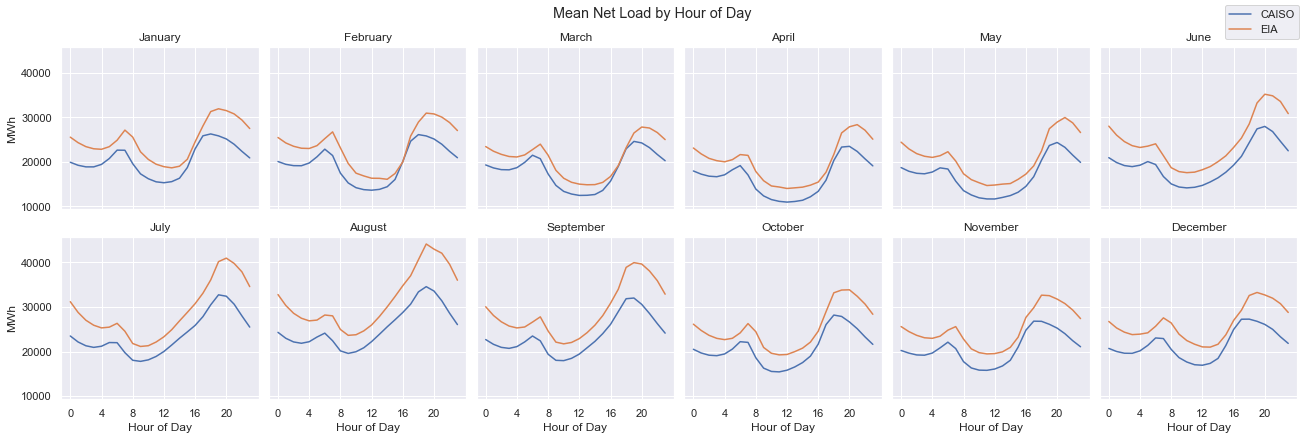

In [26]:
hourly_mu_plots('net_load')

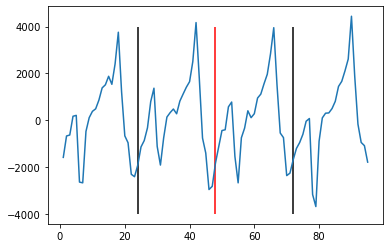

In [64]:
plt.plot(df['eia_ramp'][1:24*4])
plt.vlines(24,ymin=-4000,ymax=4000)
plt.vlines(24*2,ymin=-4000,ymax=4000,color='r')
plt.vlines(24*3,ymin=-4000,ymax=4000)

In [79]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

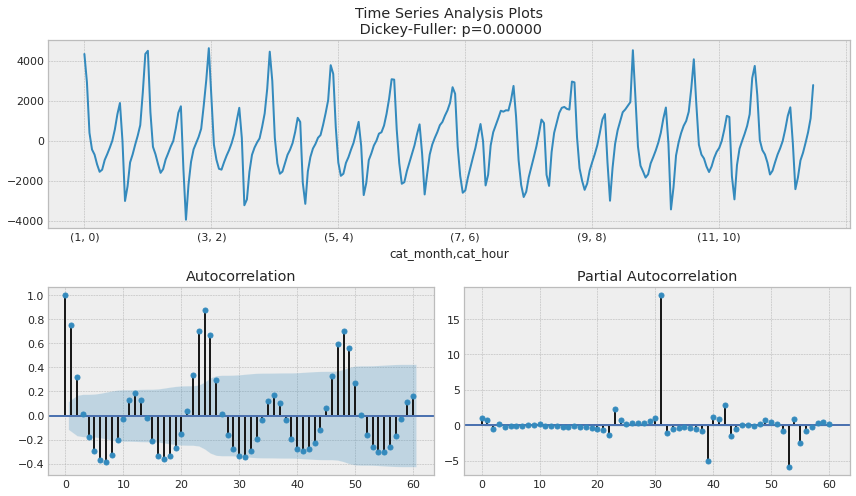

In [82]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline
tsplot(mu_df['caiso_ramp'], lags=60)